# ============================================================
## Baseline_classical_models.ipynb
## The goal of this notebook is to establish a baseline: a simple, fast, and interpretable models (SVM and LR) before moving to transformers
# ============================================================


In [ ]:
#Libraries 
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)

random.seed(42)
np.random.seed(42)


In [4]:
# Load Data

path = "C:/Users/diego/Desktop/multimodal-argmining"
train_path = f"{path}/data/gun_control_train.csv"

df = pd.read_csv(train_path)
df = df[df["stance"].isin(["support", "oppose"])].copy()
print(df["stance"].value_counts())
df.head()


stance
support    475
oppose     448
Name: count, dtype: int64


,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split
0,1372936384034447366,https://t.co/FpkVZ8ESy0,More Asian-Americans Are Buying Guns For Prote...,oppose,no,train
1,1327310308260667393,https://t.co/KrJTpJR3Ke,"""I will protect your Bill of Rights. Gun contr...",oppose,no,train
2,1334523148692312065,https://t.co/hBAV1pPCY9,#guns #2A 6-Time Olympic Shooting Medalist Say...,oppose,no,train
3,1324087921641721856,https://t.co/LfIzR6iPA3,Congratulations @ForHD65 on your victory! \n\n...,support,no,train
4,1313162243035607040,https://t.co/MZyeIP6Mtx,Dr. Cindy Banyai supports common sense gun saf...,support,no,train


In [6]:

# Text Cleaning (Same as the 01 Preprocessing notebook)
def minimal_clean(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)   # remove URLs
    text = re.sub(r"@\w+", "", text)                      # remove mentions
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["tweet_text"].apply(minimal_clean)

#Mapping
label2id = {"oppose": 0, "support": 1}
df["label"] = df["stance"].map(label2id)
df.head()

,tweet_id,tweet_url,tweet_text,stance,persuasiveness,split,clean_text,label
0,1372936384034447366,https://t.co/FpkVZ8ESy0,More Asian-Americans Are Buying Guns For Prote...,oppose,no,train,More Asian-Americans Are Buying Guns For Prote...,0
1,1327310308260667393,https://t.co/KrJTpJR3Ke,"""I will protect your Bill of Rights. Gun contr...",oppose,no,train,"""I will protect your Bill of Rights. Gun contr...",0
2,1334523148692312065,https://t.co/hBAV1pPCY9,#guns #2A 6-Time Olympic Shooting Medalist Say...,oppose,no,train,#guns #2A 6-Time Olympic Shooting Medalist Say...,0
3,1324087921641721856,https://t.co/LfIzR6iPA3,Congratulations @ForHD65 on your victory! \n\n...,support,no,train,Congratulations on your victory! We’re proud t...,1
4,1313162243035607040,https://t.co/MZyeIP6Mtx,Dr. Cindy Banyai supports common sense gun saf...,support,no,train,Dr. Cindy Banyai supports common sense gun saf...,1


In [9]:

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"],
    test_size=0.2, random_state=42, stratify=df["label"]
)

print(f"Train size: {len(X_train)}. Test size: {len(X_test)}")

Train size: 738. Test size: 185


In [10]:
#TF-IDF Vectorization
# Why we used it? Served as the “classical NLP” benchmark. Simple yet powerful enough to validate that our data and labels make sense before fine-tuning large language models.

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")

TF-IDF matrix shape: (738, 5000)


In [16]:
#Baseline Models
#In this part we're just experimenting with clasical models to know we're moving towards the right direction


#LR
lr_clf = LogisticRegression(max_iter=200, class_weight="balanced")
lr_clf.fit(X_train_tfidf, y_train)

#SVM
svm_clf = LinearSVC(class_weight="balanced")
svm_clf.fit(X_train_tfidf, y_train)


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


===== Logistic Regression =====
Accuracy:  0.8973
Precision: 0.9318
Recall:    0.8632
F1-Score:  0.8962



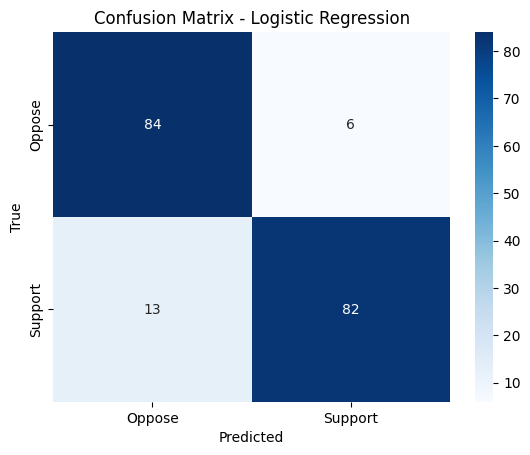

===== Linear SVM =====
Accuracy:  0.8919
Precision: 0.9310
Recall:    0.8526
F1-Score:  0.8901



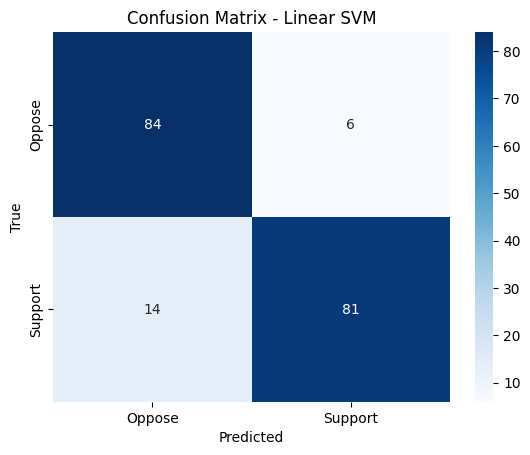

In [17]:

# Evaluation

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
    
    print(f"===== {model_name} =====")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}\n")
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Oppose", "Support"],
                yticklabels=["Oppose", "Support"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return acc, precision, recall, f1

#Run evaluation 
lr_metrics = evaluate_model(lr_clf, X_test_tfidf, y_test, "Logistic Regression")
svm_metrics = evaluate_model(svm_clf, X_test_tfidf, y_test, "Linear SVM")

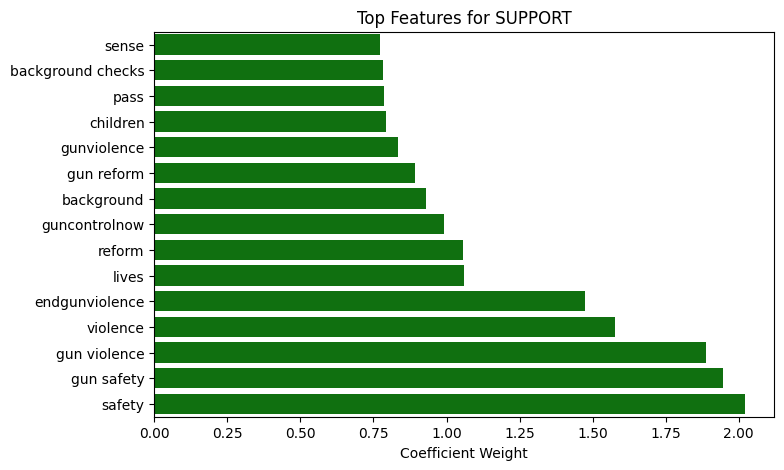

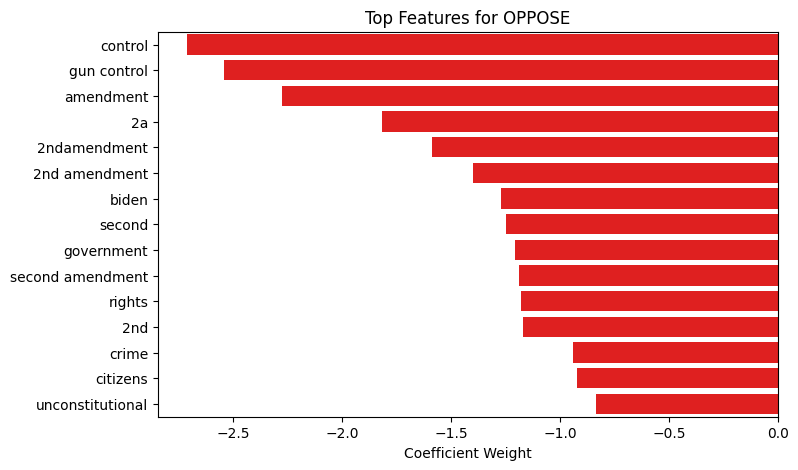

In [18]:


# Feature Importance
#small interpretability of our baseline models

def show_top_features(model, vectorizer, label, n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    coef = model.coef_[0]
    if label == 1:
        topn = np.argsort(coef)[-n:]
        color = "green"
        title = "Top Features for SUPPORT"
    else:
        topn = np.argsort(coef)[:n]
        color = "red"
        title = "Top Features for OPPOSE"
    
    top_features = feature_names[topn]
    top_weights = coef[topn]
    
    plt.figure(figsize=(8,5))
    sns.barplot(x=top_weights, y=top_features, color=color)
    plt.title(title)
    plt.xlabel("Coefficient Weight")
    plt.show()

# Top features for both labels (LR)
show_top_features(lr_clf, tfidf, label=1, n=15)
show_top_features(lr_clf, tfidf, label=0, n=15)


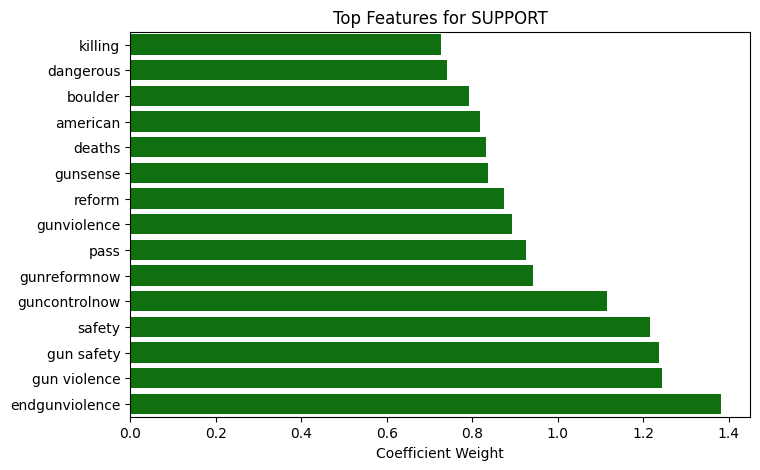

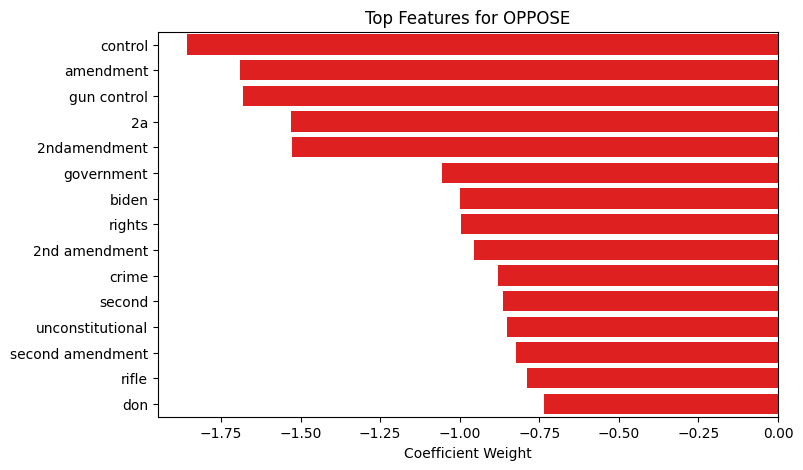

In [19]:
show_top_features(svm_clf, tfidf, label=1, n=15)
show_top_features(svm_clf, tfidf, label=0, n=15)